In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from typing import List, Callable
from itertools import product
import sys
import seaborn as sns

In [2]:
def plot_density(density_func: Callable, fpath: str = None, min_x: float = -5.0, max_x: float = 5.0, n_grid_points: int = 50, plot_contours: bool = False, my_axis=None, **kwargs):
    """
    Function to plot a probability density.
    Arguments:
        density_func: probability density function.
        fpath: save image to this file path (if given)
        min_x,max_x: float - borders of grid
        n_grid_points: int - number of grid points,
        **kwargs: arguments for density function
    Returns:
        axis object with plot.
    """

    oned_grid = np.linspace(min_x, max_x, n_grid_points)
    twod_grid = np.array([[x,y] for x,y in product(oned_grid,oned_grid)])
    extent = [oned_grid.min(), oned_grid.max(), oned_grid.min(), oned_grid.max()]
    result = density_func(x=twod_grid,**kwargs)
    if my_axis is None:
        fig,my_axis = plt.subplots()
    my_axis.imshow(result.reshape(n_grid_points,n_grid_points).transpose(),interpolation='bilinear',origin='lower', extent = extent, cmap=plt.get_cmap('YlOrRd'))
    if plot_contours:
        my_axis.contour(result.reshape(n_grid_points,n_grid_points).transpose(),interpolation='bilinear',origin='lower', extent = extent,color='black')
    if fpath is not None:
        plt.savefig(fpath)
    return my_axis

In [3]:
def get_gaussian(representation: str, x: np.array, mean: np.array = None, cov: np.array = None, **kwargs):
  """
  Function to compute Gaussian.
  representation - str: how to represent the Gaussian distribution. can be either 'density', 'log_density', 'gradient_of_density', 'gradient_of_log_density / score'
    x - np.array: shape (n,k) - data, i.e. n locations in k-dimensional euclidean space.
    mean - shape (k): mean of Gaussian
    cov - shape (k,k): covariance matrix
  """

  n = x.shape[0]
  k = x.shape[1]

  if mean is not None:
    assert len(mean) == k
    x = x - mean[None, :]

  if cov is None:
    cov = np.eye(k)
  else:
    assert cov.shape == (k, k)

  inv_cov = np.linalg.inv(cov) # inverse of cov matrix
  quadratic_product = (x * np.dot(x, inv_cov)).sum(axis=1) # compute exponent fo the normal distribution
  denominator = math.sqrt((2**x.shape[1])*np.linalg.det(cov)) # normalizing constant

  if representation == 'density':
    return np.exp(-0.5*quadratic_product)/denominator

  elif representation == 'log_density':
    return -0.5*quadratic_product - np.log(denominator)

  elif representation == 'gradient_of_density':
    # by chain rule
    return -np.dot(x,inv_cov)*np.exp(-0.5*quadratic_product[:,None])/denominator

  elif representation == 'score':
    # score is grad of log density
    return -np.dot(x, inv_cov)


def gaussian_density(**kwargs):
    """Function to get Gaussian density."""
    return get_gaussian(representation="density", **kwargs)

def gaussian_log_density(**kwargs):
    """Function to get Gaussian log density."""
    return get_gaussian(representation="log_density", **kwargs)

def gaussian_score(**kwargs):
    """Function to get Gaussian score."""
    return get_gaussian(representation="score", **kwargs)

def gaussian_grad_density(**kwargs):
    """Function to get Gaussian gradient of density."""
    return get_gaussian(representation="gradient_of_density", **kwargs)

def plot_gaussian_density(**kwargs):
    """Function to plot a Gaussian density"""
    return plot_density(density_func=gaussian_density,**kwargs)

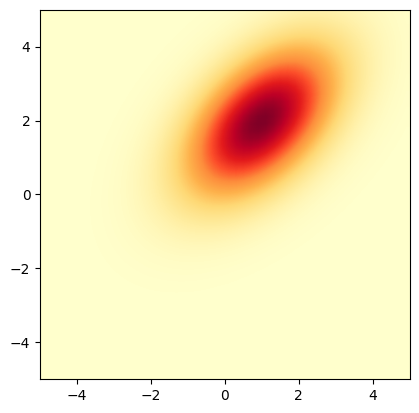

In [4]:
plot_gaussian_density(mean=np.array([1, 2]), cov=np.array([[2,1],[1,2]]));

In [5]:
def get_gaussian_mixture(representation: str, x: np.array, mean_list: List[np.array],
                         cov_list: List[np.array] = None, mixture_probs: np.array = None):
  """
  Function to compute Gaussian mixture.
  representation - str: how to represent the Gaussian distribution. can be either 'density', 'log_density', 'gradient_of_density', 'gradient_of_log_density / score'
    x - np.array: shape (n,k) - data, i.e. n locations in k-dimensional euclidean space.
    mean_list - list of mean arrays of shape (k): means of individual Gaussian distributions
    cov_list - list of covariance matrices of shape (k,k): covariance matrices of individual Gaussian distributions
  """

  if cov_list is None:
    cov_list = len(mean_list) * [None]

  if mixture_probs is None:
    mixture_probs = np.ones(len(mean_list)) / len(mean_list)

  if representation == 'density':
    #1. The density of a Gaussian mixture is the weighted sum of its individual
        #Gaussian distributions.
        density = np.zeros(shape=len(x))
        for mean,cov,prob in zip(mean_list,cov_list,mixture_probs):
            density += prob*gaussian_density(x=x,mean=mean,cov=cov)

        return density

  elif representation == 'score':
    #2. The score of a Gaussian mixture is given by the weighted sum of the individual
        #gradients of the probability density divided by the density.

        score = np.zeros(shape=(len(x), x.shape[1]))
        for mean,cov,prob in zip(mean_list,cov_list,mixture_probs):
            score += prob*get_gaussian(representation="gradient_of_density",x=x,mean=mean,cov=cov)

        # denominator of the score is the density:
        density = get_gaussian_mixture(representation="density",x=x,mean_list=mean_list,cov_list=cov_list,mixture_probs=mixture_probs)
        score = score/density[:,None]

        return score

def gaussian_mixture_density(**kwargs):
    """Function to get density of a Gaussian mixture distribution."""
    return get_gaussian_mixture(representation="density", **kwargs)

def gaussian_mixture_score(**kwargs):
    """Function to get the score of a Gaussian mixture distribution."""
    return get_gaussian_mixture(representation="score", **kwargs)

def plot_gaussian_mixture_density(**kwargs):
    """Function to plot a Gaussian mixture density."""
    return plot_density(density_func=gaussian_mixture_density,**kwargs)

In [6]:
MEAN_LIST = [np.array([-2,3]),np.array([0,0]), np.array([3,-4]),np.array([-3,-3]),np.array([6,4])]
COV_LIST = [np.array([[2,1],[1,2]]),np.array([[1,-1],[-1,4]]),np.array([[1,0.2],[0.2,1.0]]),np.eye(2),np.eye(2)]
MIXTURE_PROBS = [0.225,0.3,0.125,0.15,0.20]

/tmp/ipython-input-278216885.py:22: UserWarning: The following kwargs were not used by contour: 'interpolation', 'color'
  my_axis.contour(result.reshape(n_grid_points,n_grid_points).transpose(),interpolation='bilinear',origin='lower', extent = extent,color='black')


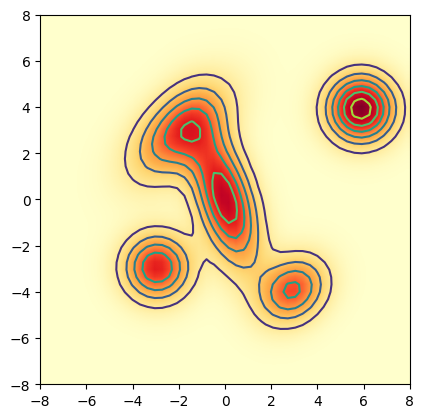

In [7]:
plot_gaussian_mixture_density(mean_list=MEAN_LIST,
                                    cov_list=COV_LIST,
                                    mixture_probs=MIXTURE_PROBS,
                                    min_x=-8.0,
                                    max_x=8.0,
                                    plot_contours=True);

In [8]:
def plot_score_vector_field(score_func: Callable, density_func: Callable, fpath: str = None, min_x: float = -5.0, max_x: float = 5.0, n_grid_points: int = 50, plot_contours: bool = False, **kwargs):
    """
    Function to plot a probability density.
    Arguments:
        density_func: probability density function.
        fpath: save image to this file path (if given)
        min_x,max_x: float - borders of grid
        n_grid_points: int - number of grid points,
        **kwargs: arguments for density function
    Returns:
        axis object with plot.
    """

    oned_grid = np.linspace(min_x, max_x, n_grid_points)
    twod_grid = np.array([[x,y] for x,y in product(oned_grid,oned_grid)])
    extent = [oned_grid.min(), oned_grid.max(), oned_grid.min(), oned_grid.max()]
    result = density_func(x=twod_grid,**kwargs)
    score = score_func(x=twod_grid,**kwargs)

    fig,my_axis = plt.subplots(figsize=(12,12))
    my_axis.imshow(result.reshape(n_grid_points,n_grid_points).transpose(),interpolation='bilinear',origin='lower', extent = extent, cmap=plt.get_cmap('YlOrRd'))
    if plot_contours:
        my_axis.contour(result.reshape(n_grid_points,n_grid_points).transpose(),interpolation='bilinear',origin='lower', extent = extent,color='black')
    if fpath is not None:
        plt.savefig(fpath)

    my_axis.quiver(twod_grid[:,0],twod_grid[:,1],score[:,0],score[:,1],scale=60.0)
    return my_axis

<Axes: >

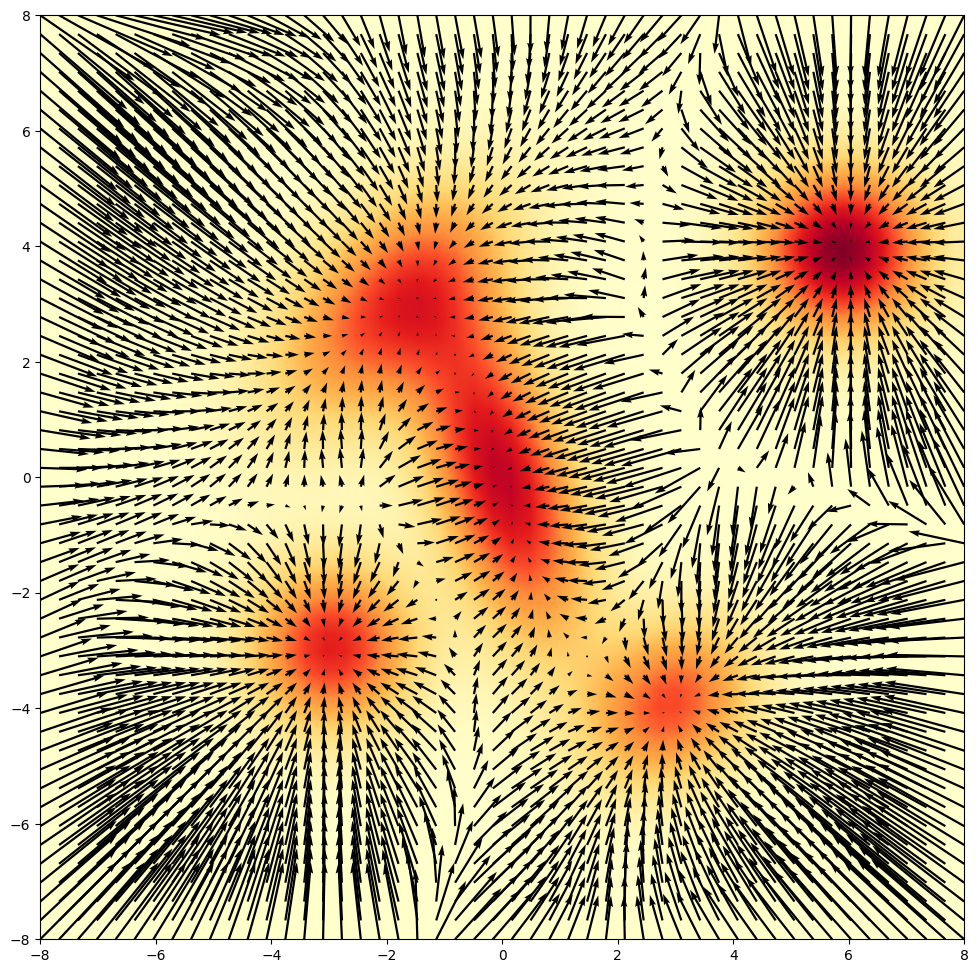

In [9]:
plot_score_vector_field(score_func=gaussian_mixture_score,
                        density_func=gaussian_mixture_density,
                        mean_list=MEAN_LIST,
                        cov_list=COV_LIST,
                        mixture_probs=MIXTURE_PROBS,
                        min_x=-8.0,
                        max_x=8.0,
                        plot_contours=False)

In [10]:
def langevin_diffusion(x_start: np.array, score_func: Callable, step_size: float, n_steps: int, **kwargs):
  """Function to compute Langevin diffusion from n starting points.
    Arguments:
       x_start - shape (n,k): starting points
       score_func: scoring function
       step_size: step size
       n_steps: number of diffusion steps
    Returns:
        np.array of shape (n_steps,n,k)
  """

  dim_data = x_start.shape[1]
  n_traj = x_start.shape[0]

  x_traj = [x_start]

  for i in range(n_steps):
    x_curr = x_traj[-1] # get last point
    score = score_func(x=x_curr,**kwargs) # get score
    noise = np.random.normal(loc=0.0,scale=1.0,size=(n_traj,dim_data)) # get noise
    x_next = x_curr + step_size*score + np.sqrt(2*step_size)*noise #Update position
    x_traj.append(x_next)

  return np.stack(x_traj)

In [11]:
N_STEPS = 100000
STEP_SIZE = 0.4

In [12]:
x_start = np.array([[1,2]])
x_traj = langevin_diffusion(x_start=x_start,
                                score_func=gaussian_mixture_score,
                                step_size=STEP_SIZE,
                                n_steps=N_STEPS,
                                mean_list=MEAN_LIST,
                                cov_list=COV_LIST,
                                mixture_probs=MIXTURE_PROBS)
x_traj = x_traj.squeeze()

Text(0.5, 1.0, 'Trajectory of Langevin diffusion up to step 5000')

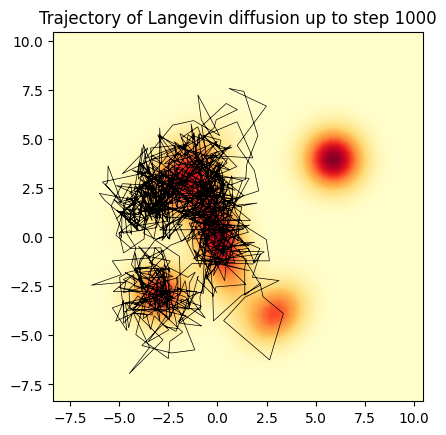

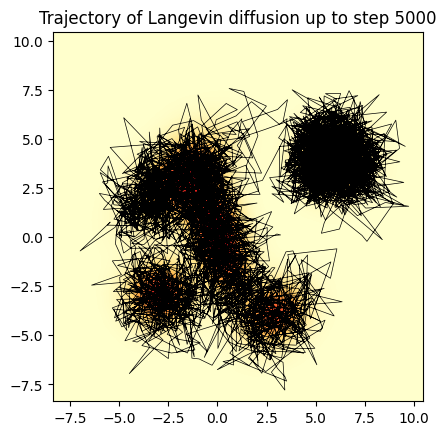

In [13]:
ax = plot_gaussian_mixture_density(mean_list=MEAN_LIST,
                                    cov_list=COV_LIST,
                                    mixture_probs=MIXTURE_PROBS,
                                    min_x=min(x_traj[:,0].min(),x_traj[:,1].min()),
                                    max_x=max(x_traj[:,0].max(),x_traj[:,1].max()));

ax.plot(x_traj[:1000,0],x_traj[:1000,1],color='black',alpha=1.0,linewidth=0.5);
ax.set_title("Trajectory of Langevin diffusion up to step 1000")

ax = plot_gaussian_mixture_density(mean_list=MEAN_LIST,
                                    cov_list=COV_LIST,
                                    mixture_probs=MIXTURE_PROBS,
                                    min_x=min(x_traj[:,0].min(),x_traj[:,1].min()),
                                    max_x=max(x_traj[:,0].max(),x_traj[:,1].max()));

ax.plot(x_traj[:5000,0],x_traj[:5000,1],color='black',alpha=1.0,linewidth=0.5);
ax.set_title("Trajectory of Langevin diffusion up to step 5000")

In [14]:
!pip install celluloid

In [15]:
from celluloid import Camera # getting the camera
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML # to show the animation in Jupyter
# the camera gets the fig we'll plot

fig, my_axis = plt.subplots(figsize=(12,12))
camera = Camera(fig)
steps = [10,20,40,80]+(80+np.exp(np.linspace(0,np.log(N_STEPS),10)).astype('int')).tolist()
steps = steps + 4*[steps[-1]]
for idx,step in enumerate(steps):
    plot_gaussian_mixture_density(mean_list=MEAN_LIST,
                            cov_list=COV_LIST,
                            mixture_probs=MIXTURE_PROBS,
                            min_x=min(x_traj[:,0].min(),x_traj[:,1].min()),
                            max_x=max(x_traj[:,0].max(),x_traj[:,1].max()),
                            plot_contours=False, my_axis=my_axis);
    sns.kdeplot(x=x_traj[:step,0],y=x_traj[:step,1],ax=my_axis,color='black')
    camera.snap()

animation = camera.animate() # animation ready
animation.save('langevin_convergence.mp4')
plt.close()
HTML(animation.to_html5_video()) # displaying the animation